<a href="https://colab.research.google.com/github/Aman56/grok/blob/main/parity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Parity learning simulations

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy

import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

n = 40 # string dimension
k = 3 # parity dimension
N = 1000 # #samples
B = 32 # batch size
lr = 0.1 # learning rate

# Data generation
def parity(n, k, samples, seed=42):

  random.seed(seed)
  input = torch.Tensor([[random.choice([-1, 1]) for j in range(n)] for i in range(samples)])
  # target = torch.prod(input[:, n//2:n//2+k], dim=1) # parity hidden in the middle
  target = torch.prod(input[:, :k], dim=1) # parity hidden in first k bits

  return input, target


class FF1(torch.nn.Module):
    def __init__(self, width=1000):
        super(FF1, self).__init__()
        self.linear1 = torch.nn.Linear(n, width)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(width, 1, bias=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

class MyHingeLoss(torch.nn.Module):
  def __init__(self):
    super(MyHingeLoss, self).__init__()

  def forward(self, output, target):
    hinge_loss = 1 - torch.mul(torch.squeeze(output), torch.squeeze(target))
    hinge_loss[hinge_loss < 0] = 0
    return hinge_loss

loss_fn = MyHingeLoss()

In [31]:
from torch.utils.data import TensorDataset, DataLoader
data = parity(n, k, N)
train_dataset = TensorDataset(data[0], data[1])
train_dataloader = DataLoader(train_dataset, batch_size=B, shuffle=True)

data = parity(n, k, 100, seed=101) # test samples
test_dataset = TensorDataset(data[0], data[1])
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [45]:
import matplotlib.pyplot as plt

T = 10000 # epochs
reg_lambda = 0.01

def acc_calc(dataloader, model):
  acc = 0
  for id, (x_batch, y_batch) in enumerate(dataloader):
    pred = model(x_batch)
    acc += (torch.sign(torch.squeeze(pred)) == y_batch.to(device)).sum().item()

  if (id > 0):
    return acc / N # train set
  else:
    return acc / x_batch.shape[0] # test set


def loss_calc(dataloader, model):
  loss = 0
  for id, (x_batch, y_batch) in enumerate(dataloader):
    pred = model(x_batch)
    loss += loss_fn(pred, y_batch.to(device)).sum().item()

  if (id > 0):
    return loss / N # train set
  else:
    return loss / x_batch.shape[0] # test set

num_seeds = 1
for seed_id in range(num_seeds):
  print(seed_id)
  model = FF1()
  model = model.to(device)
  if device == 'cuda':
    model = torch.nn.DataParallel(model)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=reg_lambda)

  # for params in model.parameters():
  #     params.data = torch.randn(params.data.shape) * alpha
  #     init_net_params.append(copy.deepcopy(params.detach()))

  train_loss, test_loss = [], []
  train_acc, test_acc = [], []
  for epoch in range(T):
    if (epoch // 250 == 1):
      print(f"Epoch {epoch + 1}\n-------------------------------")

    train_loss.append(loss_calc(train_dataloader, model))
    test_loss.append(loss_calc(test_dataloader, model))

    train_acc.append(acc_calc(train_dataloader, model))
    test_acc.append(acc_calc(test_dataloader, model))
    # Loop over batches in an epoch using DataLoader
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

      pred = model(x_batch)

      optimizer.zero_grad()
      loss = loss_fn(pred, y_batch.to(device)).mean()
      loss.backward()
      optimizer.step()

0
Epoch 251
-------------------------------
Epoch 252
-------------------------------
Epoch 253
-------------------------------
Epoch 254
-------------------------------
Epoch 255
-------------------------------
Epoch 256
-------------------------------
Epoch 257
-------------------------------
Epoch 258
-------------------------------
Epoch 259
-------------------------------
Epoch 260
-------------------------------
Epoch 261
-------------------------------
Epoch 262
-------------------------------
Epoch 263
-------------------------------
Epoch 264
-------------------------------
Epoch 265
-------------------------------
Epoch 266
-------------------------------
Epoch 267
-------------------------------
Epoch 268
-------------------------------
Epoch 269
-------------------------------
Epoch 270
-------------------------------
Epoch 271
-------------------------------
Epoch 272
-------------------------------
Epoch 273
-------------------------------
Epoch 274
----------------------

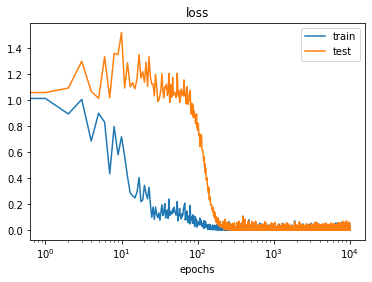

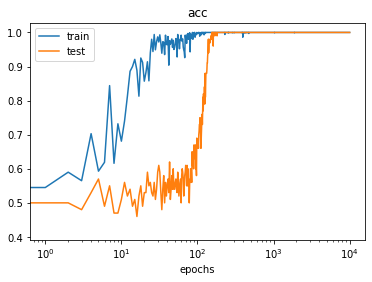

In [46]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('loss')
plt.xlabel('epochs')
plt.xscale('log')
plt.legend()
plt.show()


plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.title('acc')
plt.xlabel('epochs')
plt.xscale('log')
plt.legend()
plt.show()